In [1]:
# --- Mount & Setup ---
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [2]:
# --- Imports ---
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [3]:
# --- Load Data ---
test_df = pd.read_csv("prompt_synopsis_test.csv")
selected_rows = [20, 26, 64, 84, 88, 98, 106, 111, 127, 164,
                 190, 199, 225, 231, 242, 244, 259, 298, 10597, 10609]
test_df = test_df.iloc[selected_rows].reset_index(drop=True)
input_prompts = test_df["prompt"]
output_synopsis = test_df["synopsis"]
tags = test_df["tags_combined"]

In [4]:
# --- Hyperparameters ---
vocab_size = 40000
enc_max_len = 64
dec_max_len = 150
max_generated_length = 50
embedding_dim = 128
units = 128

In [5]:
# --- Load Tokenizer & Model ---
with open("tokenizer_RNN-GRU_40k.pkl", "rb") as f:
    tokenizer = pickle.load(f)
model = load_model("rnn_gru_model_40k.keras")

start_token_id = tokenizer.word_index["<BOS>"]
end_token_id = tokenizer.word_index["<EOS>"]
pad_token_id = tokenizer.word_index["<PAD>"]

In [6]:
# --- Build Inference Encoder ---
encoder_inputs_inf = Input(shape=(enc_max_len,), name="encoder_input")
encoder_emb = model.get_layer("embedding")(encoder_inputs_inf)
encoder_outputs_inf, state_h_inf = model.get_layer("encoder_gru")(encoder_emb)
encoder_model = Model(inputs=encoder_inputs_inf, outputs=state_h_inf)

# --- Build Inference Decoder ---
decoder_input_token = Input(shape=(1,), name="decoder_input_token")
decoder_state_input = Input(shape=(units,), name="decoder_state_input")
decoder_emb = model.get_layer("embedding_1")(decoder_input_token)
decoder_outputs, decoder_state = model.get_layer("decoder_gru")(decoder_emb, initial_state=decoder_state_input)
decoder_outputs_probs = model.get_layer("dense")(decoder_outputs)

decoder_model_inf = Model(
    inputs=[decoder_input_token, decoder_state_input],
    outputs=[decoder_outputs_probs, decoder_state]
)

In [7]:
# --- Sampling Function ---
def sample_with_temperature(preds, temperature=0.7):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.argmax(np.random.multinomial(1, preds, 1))


In [8]:
# --- Generation Function ---
def generate_synopsis(prompt, encoder_model, decoder_model, tokenizer, temp=0.7):
    input_seq = tokenizer.texts_to_sequences([prompt])
    input_seq = pad_sequences(input_seq, maxlen=enc_max_len, padding="post", value=pad_token_id)
    state = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1, 1), dtype="int32")
    target_seq[0, 0] = start_token_id
    generated_ids = []

    while True:
        output_tokens, state = decoder_model.predict([target_seq, state], verbose=0)
        sampled_token_index = sample_with_temperature(output_tokens[0, 0, :], temperature=temp)
        if sampled_token_index == end_token_id or len(generated_ids) >= max_generated_length:
            break
        generated_ids.append(sampled_token_index)
        target_seq[0, 0] = sampled_token_index

    return " ".join(
        tokenizer.index_word.get(token_id, "[UNK]") for token_id in generated_ids
        if tokenizer.index_word.get(token_id) not in ["<PAD>", "<OOV>"]
    )

In [9]:
# --- Evaluation ---
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
results = []

for i in range(len(test_df)):
    prompt = input_prompts[i]
    true = output_synopsis[i]
    tag = tags[i] if isinstance(tags[i], str) else ""

    generated = generate_synopsis(prompt, encoder_model, decoder_model_inf, tokenizer)
    emb_tag = embedding_model.encode(tag.strip())
    emb_gen = embedding_model.encode(generated.strip())
    similarity = cosine_similarity([emb_tag], [emb_gen])[0][0]

    results.append({
        "tags_combined": tag,
        "prompt": prompt,
        "generated": generated,
        "true": true,
        "cosine_similarity": similarity
    })

    print(f"\nPrompt {i+1}: {prompt}")
    print(f"Generated: {generated}")
    print(f"True:      {true}")
    print(f"Cosine Similarity: {similarity:.3f}")
    print("--------------------------------------------------")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: the same season of the original season of the second boy to the anime of the the cold of the world and a named and their father is a in a wandering she is been they to get the and
True:      on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be

In [10]:
# --- Save Results ---
test_df_results = pd.DataFrame(results)
test_df_results.to_csv("RNN-GRU_EVAL_20rows_with_cosine_similarity.csv", index=False)

In [11]:
# Show full text in cells and nice table formatting
pd.set_option('display.max_colwidth', None)
test_df_results.head(10).style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

,tags_combined,prompt,generated,true,cosine_similarity
0,adventure comedy fantasy,"Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.",the same season of the original season of the second boy to the anime of the the cold of the world and a named and their father is a in a wandering she is been they to get the and,"on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be biting off more than he can chew.",0.296875
1,mystery supernatural,Write an anime synopsis that matches 'Mystery and Supernatural'.,the based at the world of the first is a of a planet.,"the anime is set in the fictional geso ward in tokyo, a school city where an app called aicis is becoming popular. those who get the app are given supernatural powers, which they use to pursue their own selfish desires, leading to many occurrences of violence and other incidents. the story focuses on a group of detectives who solve cases related to power wielders.",0.102090
2,historical mythology shoujo,Generate a 'Historical and Mythology' themed anime targeting 'Shoujo'.,two recap of the first episodes of the girls episodes in the bluray chibi country and second teenage saves a story of the original season of and the third end on the small island.,"in the nineteenth century, we find lydia carlton living in scotland, making a living as a fairy doctor. she is one of those rare humans who can see and communicate with fairies. but no one believes her. however, edgar is in need of someone with a vast knowledge of fairy lore, and lydia is just that person. after rescuing her, he becomes her employer, but there are many secrets and emotions that seem to follow edgar, who claims to be the blue knight's earl.",0.192956
3,adventure,Write an anime synopsis that matches 'Adventure'.,episode in the planet of the new,"takashi loves reading books and especially loves alice's adventures in wonderland. one day, he buys some used books, and he finds one book thrown in. when takashi opens the book, the god of math m1 appeared. takashi is told that alice is kidnapped, and he's asked to rescue her by m1. and takashi goes on an adventure in wonderland to rescue alice.",0.226136
4,anthropomorphic comedy fantasy slice of life,"Create an anime synopsis with 'Comedy, Fantasy and Slice Of Life' and 'Anthropomorphic'.",an episode of the normal school,"in a city filled with anthropomorphic catpeople, catman lives free of rules and boundaries, doing everything he wants, which often collides with the other inhabitants of the city. created entirely in flash, with no spoken dialog, catman instead speaks in english and japanese subtitles. the series is spread across three socalled 'seasons', with only the third having been aired.",0.251394
5,action adventure drama romance sci-fi,"Write an anime synopsis that matches 'Action, Adventure, Drama, Romance and Sci-Fi'.",a year characters living,"in the backwater town of bellforest lives a 14yearold boy named renton thurston. he desires to leave his home behind and join the mercenary group known as gekkostate, hoping to find some adventure to brighten up his mundane life. however, stuck between his grandfather's insistence to become a mechanic like him and the pressure of his deceased father's legacy, the only excitement renton finds is in his pastime of riding the trapar wave particles that are dis

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


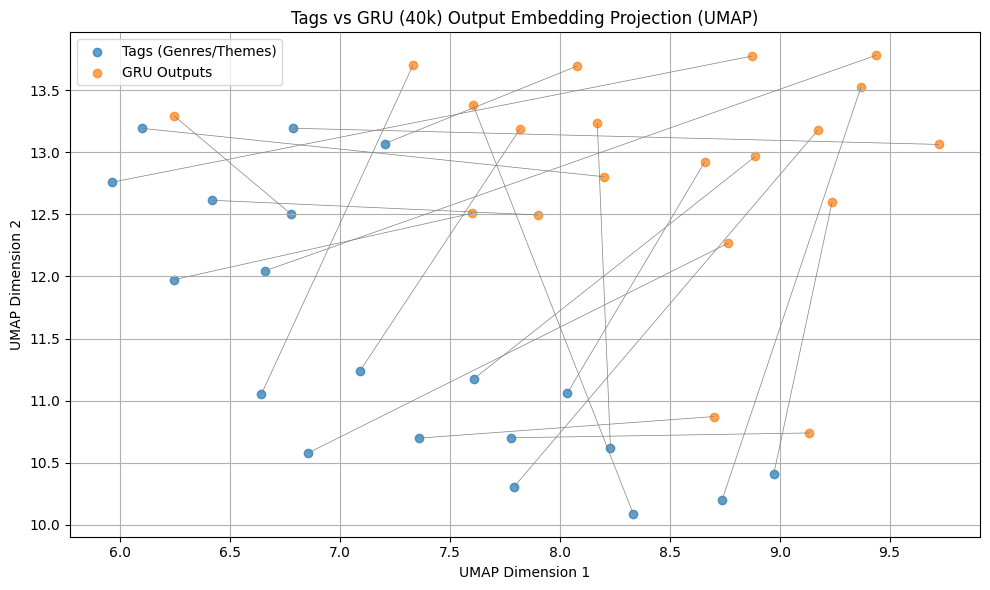

In [13]:
# --- UMAP Visualization: Tags vs RNN-GRU Outputs ---
tags_to_match = test_df_results["tags_combined"].fillna("").tolist()
generated_outputs = test_df_results["generated"].tolist()

# Compute embeddings
tags_embeddings = embedding_model.encode(tags_to_match)
output_embeddings = embedding_model.encode(generated_outputs)

# Combine and reduce dimensions
all_embeddings = np.vstack([tags_embeddings, output_embeddings])
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(all_embeddings)

# Split
n = len(tags_to_match)
umap_tags = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(umap_tags[:, 0], umap_tags[:, 1], label="Tags (Genres/Themes)", alpha=0.7)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label="GRU Outputs", alpha=0.7)

# Connect matching tag-output pairs
for i in range(n):
    plt.plot([umap_tags[i, 0], umap_outputs[i, 0]],
             [umap_tags[i, 1], umap_outputs[i, 1]],
             c='gray', linewidth=0.5)

plt.title("Tags vs GRU (40k) Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()